In [1]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import os

In [25]:
class ImagesDataset(Dataset):
    
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.img_names = os.listdir(root_dir)
        self.data_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor()])
        
    def __getitem__(self, index):
        img = Image.open(self.root_dir + '/' + self.img_names[index]).convert('L')
        item = self.data_transforms(img)
        img.close()
        max = item.max()
        min = item.min()
        if min != max:
            item = (item - min) / (max - min)
        return item.view(1, 64, 64)

    def __len__(self):
        return len(self.img_names)

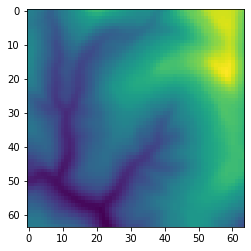

In [26]:
import matplotlib.pyplot as plt

dataset = ImagesDataset('./data')
plt.imshow(dataset[400].view(64, 64))
plt.show()

In [27]:
dataloader = DataLoader(dataset, batch_size=50, shuffle=True)

In [40]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder specification
        self.enc_cnn_1 = nn.Conv2d(1, 32, 3, padding=1)
        self.enc_cnn_2 = nn.Conv2d(32, 64, 3, padding=1)
        self.enc_cnn_3 = nn.Conv2d(64, 128, 3, padding=1)
        self.enc_cnn_4 = nn.Conv2d(128, 256, 3, padding=1)
        
        self.enc_linear_1 = nn.Linear(4096, 64)
        
        # Decoder specification
        self.dec_linear_1 = nn.Linear(64, 4096)
        
        self.dec_cnn_1 = nn.Conv2d(256, 128, 3, padding=1)
        self.dec_cnn_2 = nn.Conv2d(128, 64, 3, padding=1)
        self.dec_cnn_3 = nn.Conv2d(64, 32, 3, padding=1)
        self.dec_cnn_4 = nn.Conv2d(32, 1, 3, padding=1)
        
    def encode(self, data):
        code = self.enc_cnn_1(data)
        code = F.relu(F.max_pool2d(code, 2))
        
        code = self.enc_cnn_2(code)
        code = F.relu(F.max_pool2d(code, 2))
        
        code = self.enc_cnn_3(code)
        code = F.relu(F.max_pool2d(code, 2))
        
        code = self.enc_cnn_4(code)
        code = F.relu(F.max_pool2d(code, 2))
        
        code = code.view(code.size(0), -1)
        code = self.enc_linear_1(code)
        return code
    
    def decode(self, code):
        out = self.dec_linear_1(code)
        out = out.view(out.size(0), 256, 4, 4)
        
        out = F.interpolate(out, 8)
        out = F.relu(self.dec_cnn_1(out))
        
        out = F.interpolate(out, 16)
        out = F.relu(self.dec_cnn_2(out))
        
        out = F.interpolate(out, 32)
        out = F.relu(self.dec_cnn_3(out))
        
        out = F.interpolate(out, 64)
        out = torch.sigmoid(self.dec_cnn_4(out))
        return out
        
    def forward(self, data):
        code = self.encode(data)
        out = self.decode(code)
        return out

In [41]:
net = Autoencoder().cuda()

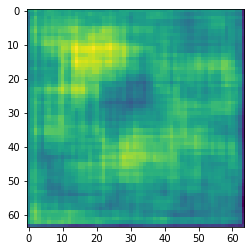

In [42]:
x = dataset[400].cuda()
out = net(x.view(1, 1, 64, 64))
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()

In [43]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs):
    for data in dataloader:
        net.zero_grad()
        x = data.cuda()
        output = net(x)
        loss = nn.MSELoss()(output, x)
        loss.backward()
        optimizer.step()
    print('epoch=' + str(epoch + 1) + ', loss=' + str(loss))

epoch=1, loss=tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
epoch=2, loss=tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward>)
epoch=3, loss=tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
epoch=4, loss=tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
epoch=5, loss=tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
epoch=6, loss=tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
epoch=7, loss=tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
epoch=8, loss=tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
epoch=9, loss=tensor(9.5771e-05, device='cuda:0', grad_fn=<MseLossBackward>)
epoch=10, loss=tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)


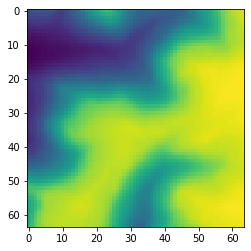

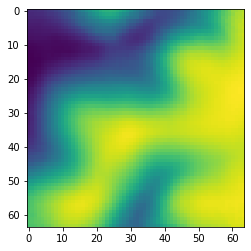

In [59]:
img = dataset[458]
x = img.cuda()
plt.imshow(img.view(64, 64))
plt.show()
output = net(x.view(-1, 1, 64, 64))
plt.imshow(output.view(64, 64).cpu().detach().numpy())
plt.show()

In [52]:
#torch.save(net.state_dict(), './conv_autoencoder_save')

In [15]:
net.load_state_dict(torch.load('./conv_autoencoder_save'))

<All keys matched successfully>

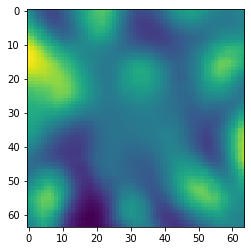

In [65]:
code = torch.rand(64).cuda()
output = net.decode(code.view(1, 64))
plt.imshow(output.view(64, 64).cpu().detach().numpy())
plt.show()